In [1]:
import numpy as np
import matplotlib.pyplot as plt

4.5 計算例

4.5.1 衝撃波管問題 \
使用スキーム：HLLD法・MUSCL(minmod)・中点法 \
※時間ステップは固定している。本来は各ステップで調整するもの

In [28]:
def minmod(x, y):
    return np.sign(x) * np.maximum(0, np.minimum(np.abs(x), np.sign(x)*y))


def get_U_parameters_1(rho, u, v, w, Bx, By, Bz, e, pT, pT_1, S, SM):
    u1 = SM
    v1 = v - Bx * By * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2)
    w1 = w - Bx * Bz * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2)
    Bx1 = Bx #1次元だからこれでいいはず
    By1 = By * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2)
    Bz1 = Bz * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2)
    e1 = ((S - u) * e - pT * u + pT_1 * SM + Bx * ((u*Bx + v*By + w*Bz) - (u1*Bx1 + v1*By1 + w1*Bz1))) / (S - SM)
    
    return u1, v1, w1, Bx1, By1, Bz1, e1


def get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx1_L, Bx1_R, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM):
    u2 = SM
    Bx2 = Bx1_L #1次元だからこれでいいはず
    v2 = (np.sqrt(rho1_L)*v1_L + np.sqrt(rho1_R)*v1_R + (By1_R - By1_L)*np.sign(Bx2)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    w2 = (np.sqrt(rho1_L)*w1_L + np.sqrt(rho1_R)*w1_R + (Bz1_R - Bz1_L)*np.sign(Bx2)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    By2 = (np.sqrt(rho1_L)*By1_R + np.sqrt(rho1_R)*By1_L + np.sqrt(rho1_L*rho1_R)*(v1_R - v1_L)*np.sign(Bx2)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    Bz2 = (np.sqrt(rho1_L)*Bz1_R + np.sqrt(rho1_R)*Bz1_L + np.sqrt(rho1_L*rho1_R)*(w1_R - w1_L)*np.sign(Bx2)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    e2_L = e1_L - np.sqrt(rho1_L) * ((u1_L*Bx1_L + v1_L*By1_L + w1_L*Bz1_L) - (u2*Bx2 + v2*By2 + w2*Bz2)) * np.sign(Bx2)
    e2_R = e1_R + np.sqrt(rho1_R) * ((u1_R*Bx1_R + v1_R*By1_R + w1_R*Bz1_R) - (u2*Bx2 + v2*By2 + w2*Bz2)) * np.sign(Bx2)

    return u2, v2, w2, Bx2, By2, Bz2, e2_L, e2_R


def get_flux(rho, u, v, w, Bx, By, Bz, e, pT, F):
    F[0, :] = rho * u
    F[1, :] = rho * u**2 + pT - Bx**2
    F[2, :] = rho * u * v - Bx * By
    F[3, :] = rho * u * w - Bx * Bz 
    F[4, :] = np.zeros(rho.shape)
    F[5, :] = u * By - v * Bx
    F[6, :] = u * Bz - w * Bx
    F[7, :] = (e + pT) * u - Bx * (Bx*u + By*v + Bz*w)
    return F


def get_flux_HLLD(U, gamma, F):
    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    pT = p + (Bx**2+By**2+Bz**2)/2
    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    fast_alfven = 1/np.sqrt(2) * np.sqrt(cs**2 + ca**2 + np.sqrt((cs**2+ca**2)**2 - 4 * cs**2 * ca**2))

    rho_L = rho + 1/2 * minmod(rho - np.roll(rho, 1), np.roll(rho, -1) - rho)
    u_L = u + 1/2 * minmod(u - np.roll(u, 1), np.roll(u, -1) - u)
    v_L = v + 1/2 * minmod(v - np.roll(v, 1), np.roll(v, -1) - v)
    w_L = w + 1/2 * minmod(w - np.roll(w, 1), np.roll(w, -1) - w)
    Bx_L = Bx + 1/2 * minmod(Bx - np.roll(Bx, 1), np.roll(Bx, -1) - Bx)
    By_L = By + 1/2 * minmod(By - np.roll(By, 1), np.roll(By, -1) - By)
    Bz_L = Bz + 1/2 * minmod(Bz - np.roll(Bz, 1), np.roll(Bz, -1) - Bz)
    e_L = e + 1/2 * minmod(e - np.roll(e, 1), np.roll(e, -1) - e)
    pT_L = pT + 1/2 * minmod(pT - np.roll(pT, 1), np.roll(pT, -1) - pT)
    fast_alfven_L = fast_alfven + 1/2 * minmod(fast_alfven - np.roll(fast_alfven, 1), np.roll(fast_alfven, -1) - fast_alfven)

    rho_R = np.roll(rho, -1) - 1/2 * minmod(np.roll(rho, -1) - rho, np.roll(rho, -2) - np.roll(rho, -1))
    u_R = np.roll(u, -1) - 1/2 * minmod(np.roll(u, -1) - u, np.roll(u, -2) - np.roll(u, -1))
    v_R = np.roll(v, -1) - 1/2 * minmod(np.roll(v, -1) - v, np.roll(v, -2) - np.roll(v, -1))
    w_R = np.roll(w, -1) - 1/2 * minmod(np.roll(w, -1) - w, np.roll(w, -2) - np.roll(w, -1))
    Bx_R = np.roll(Bx, -1) - 1/2 * minmod(np.roll(Bx, -1) - Bx, np.roll(Bx, -2) - np.roll(Bx, -1))
    By_R = np.roll(By, -1) - 1/2 * minmod(np.roll(By, -1) - By, np.roll(By, -2) - np.roll(By, -1))
    Bz_R = np.roll(Bz, -1) - 1/2 * minmod(np.roll(Bz, -1) - Bz, np.roll(Bz, -2) - np.roll(Bz, -1))
    e_R = np.roll(e, -1) - 1/2 * minmod(np.roll(e, -1) - e, np.roll(e, -2) - np.roll(e, -1))
    pT_R = np.roll(pT, -1) - 1/2 * minmod(np.roll(pT, -1) - pT, np.roll(pT, -2) - np.roll(pT, -1))
    fast_alfven_R = np.roll(fast_alfven, -1) - 1/2 * minmod(np.roll(fast_alfven, -1) - fast_alfven, np.roll(fast_alfven, -2) - np.roll(fast_alfven, -1))

    S_L = np.minimum(u_L, u_R) - np.maximum(fast_alfven_L, fast_alfven_R)
    S_R = np.maximum(u_L, u_R) + np.maximum(fast_alfven_L, fast_alfven_R)

    SM = ((S_R - u_R)*rho_R*u_R - (S_L - u_L)*rho_L*u_L - pT_R + pT_L) / ((S_R - u_R)*rho_R - (S_L - u_L)*rho_L)
    pT1 = ((S_R - u_R)*rho_R*pT_L - (S_L - u_L)*rho_L*pT_R + rho_L*rho_R*(S_R - u_R)*(S_L - u_L)*(u_R - u_L)) / ((S_R - u_R)*rho_R - (S_L - u_L)*rho_L)
    pT1_L = pT1
    pT1_R = pT1
    rho1_L = rho_L * (S_L - u_L) / (S_L - SM)
    rho1_R = rho_R * (S_R - u_R) / (S_R - SM)
    u1_L, v1_L, w1_L, Bx1_L, By1_L, Bz1_L, e1_L = get_U_parameters_1(rho_L, u_L, v_L, w_L, Bx_L, By_L, Bz_L, e_L, pT_L, pT1_L, S_L, SM)
    u1_R, v1_R, w1_R, Bx1_R, By1_R, Bz1_R, e1_R = get_U_parameters_1(rho_R, u_R, v_R, w_R, Bx_R, By_R, Bz_R, e_R, pT_R, pT1_R, S_R, SM)

    S1_L = SM - np.abs(Bx1_L)/np.sqrt(rho1_L) #Bxの扱いはどうする？　1次元だからこれでいいはず…
    S1_R = SM + np.abs(Bx1_R)/np.sqrt(rho1_R) #Bxの扱いはどうする？　1次元だからこれでいいはず…

    u2, v2, w2, Bx2, By2, Bz2, e2_L, e2_R = get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx1_L, Bx1_R, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM)
    pT2 = pT1 #全圧力は一定のスキーム（なはず）
    pT2_L = pT2 
    pT2_R = pT2
    rho2_L = rho1_L
    rho2_R = rho1_R

    # Fの選択
    F_L = np.zeros(F.shape)
    F1_L = np.zeros(F.shape)
    F2_L = np.zeros(F.shape)
    F_R = np.zeros(F.shape)
    F1_R = np.zeros(F.shape)
    F2_R = np.zeros(F.shape)
    F_L = get_flux(rho_L, u_L, v_L, w_L, Bx_L, By_L, Bz_L, e_L, pT_L, F_L)
    F1_L = get_flux(rho1_L, u1_L, v1_L, w1_L, Bx1_L, By1_L, Bz1_L, e1_L, pT1_L, F1_L)
    F2_L = get_flux(rho2_L, u2, v2, w2, Bx2, By2, Bz2, e2_L, pT2_L, F2_L)
    F_R = get_flux(rho_R, u_R, v_R, w_R, Bx_R, By_R, Bz_R, e_R, pT_R, F_R)
    F1_R = get_flux(rho1_R, u1_R, v1_R, w1_R, Bx1_R, By1_R, Bz1_R, e1_R, pT1_R, F1_R)
    F2_R = get_flux(rho2_R, u2, v2, w2, Bx2, By2, Bz2, e2_R, pT2_R, F2_R)

    F = F_L * (S_L > 0) + F1_L * ((S_L <= 0) & (0 < S1_L)) + F2_L * ((S1_L <= 0) & (0 < SM)) \
      + F_R * (S_R <= 0) + F1_R * ((S1_R <= 0) & (0 < S_R)) + F2_R * ((SM <= 0) & (0 < S1_R))
    
    return F

In [29]:
dx = 0.001
dt = 0.0002
x = np.arange(0.0, 1.0, dx)
nmax = len(x)

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 1.0
rho_R_init = 0.125
velocity_L_init = np.array([0.0, 0.0, 0.0])
velocity_R_init = np.array([0.0, 0.0, 0.0])
B_L_init = np.array([0.75, 1.0, 0.0])
B_R_init = np.array([0.75, -1.0, 0.0])
p_L_init = 1.0
p_R_init = 0.1
U[0, x < 0.5] = rho_L_init
U[0, x >= 0.5] = rho_R_init
U[1, x < 0.5] = rho_L_init * velocity_L_init[0]
U[1, x >= 0.5] = rho_R_init * velocity_R_init[0]
U[2, x < 0.5] = rho_L_init * velocity_L_init[1]
U[2, x >= 0.5] = rho_R_init * velocity_R_init[1]
U[3, x < 0.5] = rho_L_init * velocity_L_init[2]
U[3, x >= 0.5] = rho_R_init * velocity_R_init[2]
U[4, x < 0.5] = B_L_init[0]
U[4, x >= 0.5] = B_R_init[0]
U[5, x < 0.5] = B_L_init[1]
U[5, x >= 0.5] = B_R_init[1]
U[6, x < 0.5] = B_L_init[2]
U[6, x >= 0.5] = B_R_init[2]
U[7, x < 0.5] = p_L_init/(gamma-1) + rho_L_init * np.linalg.norm(velocity_L_init)**2/2 + np.linalg.norm(B_L_init)**2/2
U[7, x >= 0.5] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)

In [30]:
#中点法
step = int(0.1/dt)
for t in range(step+1):
    U_bar = U.copy()
    
    F = get_flux_HLLD(U, gamma, dx, dt, F)
    
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    F_bar = get_flux_HLLD(U_bar, gamma, dx, dt, F_bar)
    F = 1/2 * (F + F_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

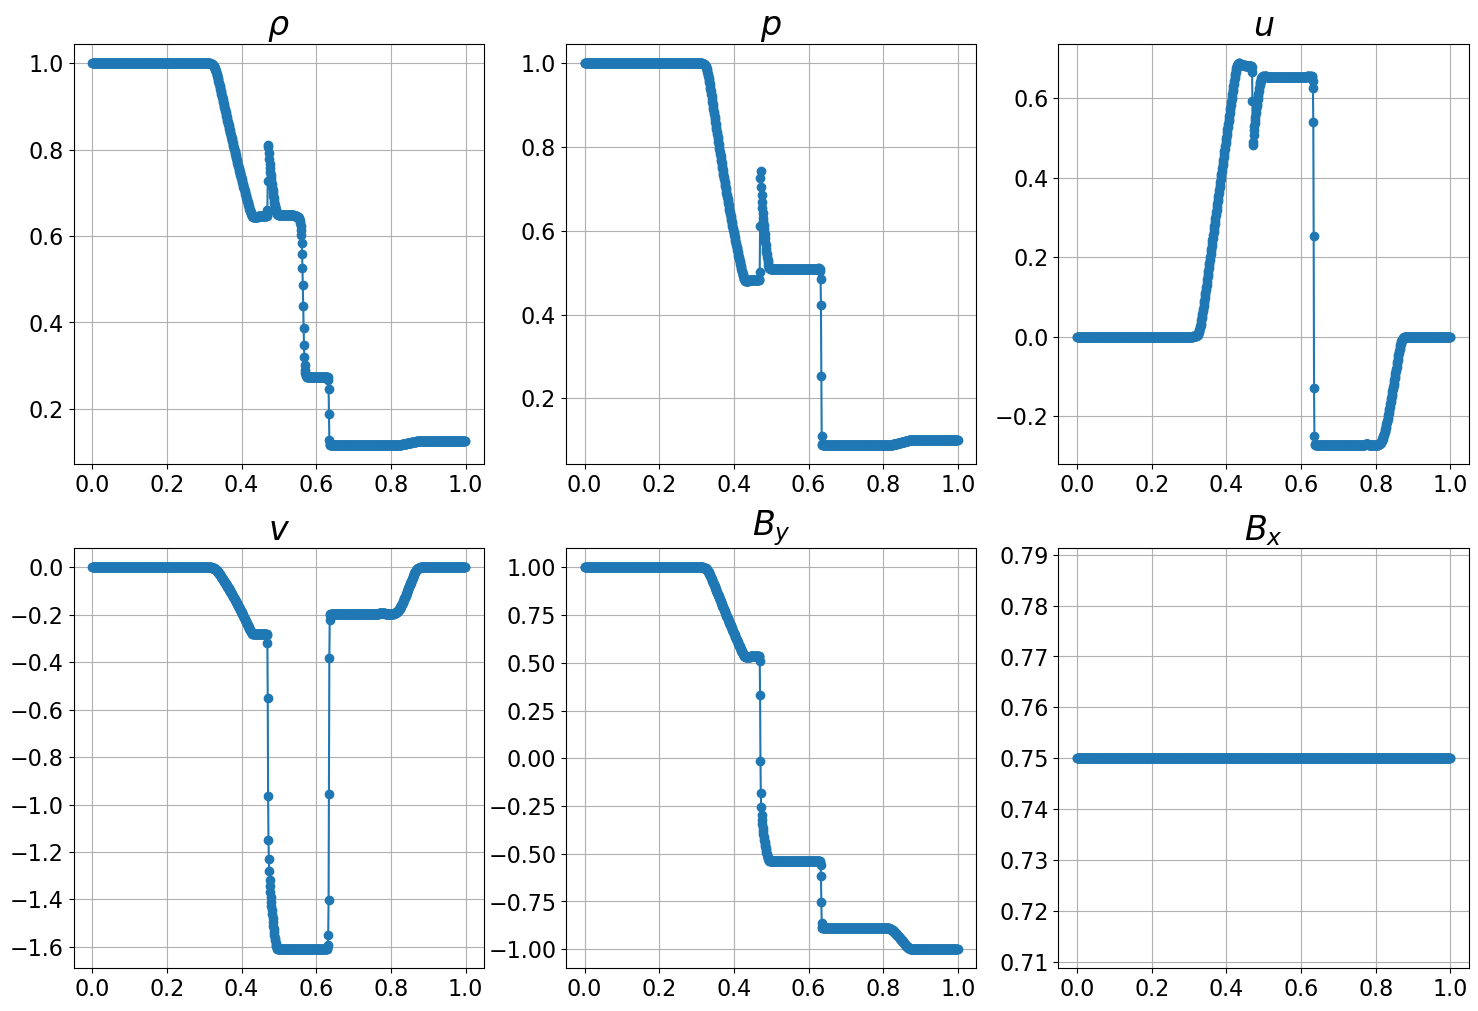

In [31]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x, rho, marker='o')
ax2.plot(x, p, marker='o')
ax3.plot(x, u, marker='o')
ax4.plot(x, v, marker='o')
ax5.plot(x, By, marker='o')
ax6.plot(x, Bx, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_x$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

4.5.2 オルスザッグ・タングの渦問題 \
使用スキーム：HLLD法・MUSCL(minmod)・中点法 \
※時間ステップは固定している。本来は各ステップで調整するもの

In [2]:
def minmod(x, y):
    return np.sign(x) * np.maximum(0, np.minimum(np.abs(x), np.sign(x)*y))


def get_U_parameters_1(rho, u, v, w, Bx, By, Bz, e, pT, pT_1, S, SM):
    u1 = SM
    v1 = v - Bx * By * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2)
    w1 = w - Bx * Bz * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2)
    Bx1 = Bx #1次元だからこれでいいはず
    By1 = By * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2)
    Bz1 = Bz * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2)
    e1 = ((S - u) * e - pT * u + pT_1 * SM + Bx * ((u*Bx + v*By + w*Bz) - (u1*Bx1 + v1*By1 + w1*Bz1))) / (S - SM)
    
    return u1, v1, w1, Bx1, By1, Bz1, e1


def get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx1_L, Bx1_R, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM):
    u2 = SM
    Bx2 = Bx1_L #1次元だからこれでいいはず
    v2 = (np.sqrt(rho1_L)*v1_L + np.sqrt(rho1_R)*v1_R + (By1_R - By1_L)*np.sign(Bx2)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    w2 = (np.sqrt(rho1_L)*w1_L + np.sqrt(rho1_R)*w1_R + (Bz1_R - Bz1_L)*np.sign(Bx2)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    By2 = (np.sqrt(rho1_L)*By1_R + np.sqrt(rho1_R)*By1_L + np.sqrt(rho1_L*rho1_R)*(v1_R - v1_L)*np.sign(Bx2)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    Bz2 = (np.sqrt(rho1_L)*Bz1_R + np.sqrt(rho1_R)*Bz1_L + np.sqrt(rho1_L*rho1_R)*(w1_R - w1_L)*np.sign(Bx2)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    e2_L = e1_L - np.sqrt(rho1_L) * ((u1_L*Bx1_L + v1_L*By1_L + w1_L*Bz1_L) - (u2*Bx2 + v2*By2 + w2*Bz2)) * np.sign(Bx2)
    e2_R = e1_R + np.sqrt(rho1_R) * ((u1_R*Bx1_R + v1_R*By1_R + w1_R*Bz1_R) - (u2*Bx2 + v2*By2 + w2*Bz2)) * np.sign(Bx2)

    return u2, v2, w2, Bx2, By2, Bz2, e2_L, e2_R


def get_L_component(rho, u, v, w, Bx, By, Bz, e, pT, fast_alfven, axis):
    rho_L = rho + 1/2 * minmod(rho - np.roll(rho, 1, axis=axis), np.roll(rho, -1, axis=axis) - rho)
    u_L = u + 1/2 * minmod(u - np.roll(u, 1, axis=axis), np.roll(u, -1, axis=axis) - u)
    v_L = v + 1/2 * minmod(v - np.roll(v, 1, axis=axis), np.roll(v, -1, axis=axis) - v)
    w_L = w + 1/2 * minmod(w - np.roll(w, 1, axis=axis), np.roll(w, -1, axis=axis) - w)
    Bx_L = Bx + 1/2 * minmod(Bx - np.roll(Bx, 1, axis=axis), np.roll(Bx, -1, axis=axis) - Bx)
    By_L = By + 1/2 * minmod(By - np.roll(By, 1, axis=axis), np.roll(By, -1, axis=axis) - By)
    Bz_L = Bz + 1/2 * minmod(Bz - np.roll(Bz, 1, axis=axis), np.roll(Bz, -1, axis=axis) - Bz)
    e_L = e + 1/2 * minmod(e - np.roll(e, 1, axis=axis), np.roll(e, -1, axis=axis) - e)
    pT_L = pT + 1/2 * minmod(pT - np.roll(pT, 1, axis=axis), np.roll(pT, -1, axis=axis) - pT)
    fast_alfven_L = fast_alfven + 1/2 * minmod(fast_alfven - np.roll(fast_alfven, 1, axis=axis), np.roll(fast_alfven, -1, axis=axis) - fast_alfven)

    return rho_L, u_L, v_L, w_L, Bx_L, By_L, Bz_L, e_L, pT_L, fast_alfven_L


def get_R_component(rho, u, v, w, Bx, By, Bz, e, pT, fast_alfven, axis):
    rho_R = np.roll(rho, -1, axis=axis) - 1/2 * minmod(np.roll(rho, -1, axis=axis) - rho, np.roll(rho, -2, axis=axis) - np.roll(rho, -1, axis=axis))
    u_R = np.roll(u, -1, axis=axis) - 1/2 * minmod(np.roll(u, -1, axis=axis) - u, np.roll(u, -2, axis=axis) - np.roll(u, -1, axis=axis))
    v_R = np.roll(v, -1, axis=axis) - 1/2 * minmod(np.roll(v, -1, axis=axis) - v, np.roll(v, -2, axis=axis) - np.roll(v, -1, axis=axis))
    w_R = np.roll(w, -1, axis=axis) - 1/2 * minmod(np.roll(w, -1, axis=axis) - w, np.roll(w, -2, axis=axis) - np.roll(w, -1, axis=axis))
    Bx_R = np.roll(Bx, -1, axis=axis) - 1/2 * minmod(np.roll(Bx, -1, axis=axis) - Bx, np.roll(Bx, -2, axis=axis) - np.roll(Bx, -1, axis=axis))
    By_R = np.roll(By, -1, axis=axis) - 1/2 * minmod(np.roll(By, -1, axis=axis) - By, np.roll(By, -2, axis=axis) - np.roll(By, -1, axis=axis))
    Bz_R = np.roll(Bz, -1, axis=axis) - 1/2 * minmod(np.roll(Bz, -1, axis=axis) - Bz, np.roll(Bz, -2, axis=axis) - np.roll(Bz, -1, axis=axis))
    e_R = np.roll(e, -1, axis=axis) - 1/2 * minmod(np.roll(e, -1, axis=axis) - e, np.roll(e, -2, axis=axis) - np.roll(e, -1, axis=axis))
    pT_R = np.roll(pT, -1, axis=axis) - 1/2 * minmod(np.roll(pT, -1, axis=axis) - pT, np.roll(pT, -2, axis=axis) - np.roll(pT, -1, axis=axis))
    fast_alfven_R = np.roll(fast_alfven, -1, axis=axis) - 1/2 * minmod(np.roll(fast_alfven, -1, axis=axis) - fast_alfven, np.roll(fast_alfven, -2, axis=axis) - np.roll(fast_alfven, -1, axis=axis))

    return rho_R, u_R, v_R, w_R, Bx_R, By_R, Bz_R, e_R, pT_R, fast_alfven_R


def get_flux(rho, u, v, w, Bx, By, Bz, e, pT, F):
    F[0, :, :] = rho * u
    F[1, :, :] = rho * u**2 + pT - Bx**2
    F[2, :, :] = rho * u * v - Bx * By
    F[3, :, :] = rho * u * w - Bx * Bz 
    F[4, :, :] = np.zeros(rho.shape)
    F[5, :, :] = u * By - v * Bx
    F[6, :, :] = u * Bz - w * Bx
    F[7, :, :] = (e + pT) * u - Bx * (Bx*u + By*v + Bz*w)
    return F


def get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis):

    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    pT = p + (Bx**2+By**2+Bz**2)/2
    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    fast_alfven = 1/np.sqrt(2) * np.sqrt(cs**2 + ca**2 + np.sqrt((cs**2+ca**2)**2 - 4 * cs**2 * ca**2))

    rho_L, u_L, v_L, w_L, Bx_L, By_L, Bz_L, e_L, pT_L, fast_alfven_L = get_L_component(rho, u, v, w, Bx, By, Bz, e, pT, fast_alfven, axis=axis)
    rho_R, u_R, v_R, w_R, Bx_R, By_R, Bz_R, e_R, pT_R, fast_alfven_R = get_R_component(rho, u, v, w, Bx, By, Bz, e, pT, fast_alfven, axis=axis)

    S_L = np.minimum(u_L, u_R) - np.maximum(fast_alfven_L, fast_alfven_R)
    S_R = np.maximum(u_L, u_R) + np.maximum(fast_alfven_L, fast_alfven_R)

    SM = ((S_R - u_R)*rho_R*u_R - (S_L - u_L)*rho_L*u_L - pT_R + pT_L) / ((S_R - u_R)*rho_R - (S_L - u_L)*rho_L)
    pT1 = ((S_R - u_R)*rho_R*pT_L - (S_L - u_L)*rho_L*pT_R + rho_L*rho_R*(S_R - u_R)*(S_L - u_L)*(u_R - u_L)) / ((S_R - u_R)*rho_R - (S_L - u_L)*rho_L)
    pT1_L = pT1
    pT1_R = pT1
    rho1_L = rho_L * (S_L - u_L) / (S_L - SM)
    rho1_R = rho_R * (S_R - u_R) / (S_R - SM)
    u1_L, v1_L, w1_L, Bx1_L, By1_L, Bz1_L, e1_L = get_U_parameters_1(rho_L, u_L, v_L, w_L, Bx_L, By_L, Bz_L, e_L, pT_L, pT1_L, S_L, SM)
    u1_R, v1_R, w1_R, Bx1_R, By1_R, Bz1_R, e1_R = get_U_parameters_1(rho_R, u_R, v_R, w_R, Bx_R, By_R, Bz_R, e_R, pT_R, pT1_R, S_R, SM)

    S1_L = SM - np.abs(Bx1_L)/np.sqrt(rho1_L) #Bxの扱いはどうする？　1次元だからこれでいいはず…
    S1_R = SM + np.abs(Bx1_R)/np.sqrt(rho1_R) #Bxの扱いはどうする？　1次元だからこれでいいはず…

    u2, v2, w2, Bx2, By2, Bz2, e2_L, e2_R = get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx1_L, Bx1_R, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM)
    pT2 = pT1 #全圧力は一定のスキーム（なはず）
    pT2_L = pT2 
    pT2_R = pT2
    rho2_L = rho1_L
    rho2_R = rho1_R

    # Fの選択
    F_L = np.zeros(F.shape)
    F1_L = np.zeros(F.shape)
    F2_L = np.zeros(F.shape)
    F_R = np.zeros(F.shape)
    F1_R = np.zeros(F.shape)
    F2_R = np.zeros(F.shape)
    F_L = get_flux(rho_L, u_L, v_L, w_L, Bx_L, By_L, Bz_L, e_L, pT_L, F_L)
    F1_L = get_flux(rho1_L, u1_L, v1_L, w1_L, Bx1_L, By1_L, Bz1_L, e1_L, pT1_L, F1_L)
    F2_L = get_flux(rho2_L, u2, v2, w2, Bx2, By2, Bz2, e2_L, pT2_L, F2_L)
    F_R = get_flux(rho_R, u_R, v_R, w_R, Bx_R, By_R, Bz_R, e_R, pT_R, F_R)
    F1_R = get_flux(rho1_R, u1_R, v1_R, w1_R, Bx1_R, By1_R, Bz1_R, e1_R, pT1_R, F1_R)
    F2_R = get_flux(rho2_R, u2, v2, w2, Bx2, By2, Bz2, e2_R, pT2_R, F2_R)

    F = F_L * (S_L > 0) + F1_L * ((S_L <= 0) & (0 < S1_L)) + F2_L * ((S1_L <= 0) & (0 < SM)) \
      + F_R * (S_R <= 0) + F1_R * ((S1_R <= 0) & (0 < S_R)) + F2_R * ((SM <= 0) & (0 < S1_R))
    
    return F

In [47]:
nx = 256
ny = 256
x_max = 2 * np.pi 
y_max = 2 * np.pi
dx = x_max / nx
dy = y_max / ny
dt = 0.0
CFL = 0.5
x = np.arange(0.0, x_max, dx)
y = np.arange(0.0, y_max, dy)
X, Y = np.meshgrid(x, y)

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0], y.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_init = gamma**2
u_init = -np.sin(Y)
v_init = np.sin(X)
w_init = np.zeros(X.shape)
Bx_init = -np.sin(Y)
By_init = np.sin(2*X)
Bz_init = np.zeros(X.shape)
p_init = gamma
U[0, :, :] = rho_init
U[1, :, :] = rho_init * u_init
U[2, :, :] = rho_init * v_init
U[3, :, :] = rho_init * w_init
U[4, :, :] = Bx_init
U[5, :, :] = By_init
U[6, :, :] = Bz_init
U[7, :, :] = p_init/(gamma-1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)
G = np.zeros(U.shape)
G_bar = np.zeros(G.shape)

In [48]:
#中点法
step = 10000
time = 0.0
for t in range(step+1):
    U_bar = U.copy()

    rho = U[0, :, :]
    u = U[1, :, :] / rho
    v = U[2, :, :] / rho
    w = U[3, :, :] / rho
    Bx = U[4, :, :]
    By = U[5, :, :]
    Bz = U[6, :, :]
    e = U[7, :, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)
    # get_flux_HLLDを使いまわす
    G = get_flux_HLLD(rho, v, w, u, By, Bz, Bx, e, gamma, G, axis=1)
    # Gの順番替え。get_flux_HLLDを使いまわすだけだとダメ
    G_tmp = G.copy()
    G[1, :, :] = G_tmp[3, :, :]
    G[2, :, :] = G_tmp[1, :, :]
    G[3, :, :] = G_tmp[2, :, :]
    G[4, :, :] = G_tmp[6, :, :]
    G[5, :, :] = G_tmp[4, :, :]
    G[6, :, :] = G_tmp[5, :, :]

    # 軸に注意。Fは3元テンソル(成分と座標) ※rhoとかは2次元テンソル(座標)
    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * dx / np.max(np.sqrt(cs**2+ca**2))
    time += dt
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1))
    U_bar += -dt/dy * (G - np.roll(G, 1, axis=2))
    # 周期境界条件

    rho = U_bar[0, :, :]
    u = U_bar[1, :, :] / rho
    v = U_bar[2, :, :] / rho
    w = U_bar[3, :, :] / rho
    Bx = U_bar[4, :, :]
    By = U_bar[5, :, :]
    Bz = U_bar[6, :, :]
    e = U_bar[7, :, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    G_bar = get_flux_HLLD(rho, v, w, u, By, Bz, Bx, e, gamma, G_bar, axis=1)
    G_tmp = G_bar.copy()
    G_bar[1, :, :] = G_tmp[3, :, :]
    G_bar[2, :, :] = G_tmp[1, :, :]
    G_bar[3, :, :] = G_tmp[2, :, :]
    G_bar[4, :, :] = G_tmp[6, :, :]
    G_bar[5, :, :] = G_tmp[4, :, :]
    G_bar[6, :, :] = G_tmp[5, :, :]
    F = 1/2 * (F + F_bar)
    G = 1/2 * (G + G_bar)

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * dx / np.max(np.sqrt(cs**2+ca**2))
    time += dt
    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    U += -dt/dy * (G - np.roll(G, 1, axis=2))

    if np.isnan(time):
        print(f"{t} steps : Calculation is crashed!")
        break

    if time > 0.35:
        print(f"{t} steps : Calculation is stopped")
        break

18 steps : Calculation is stopped


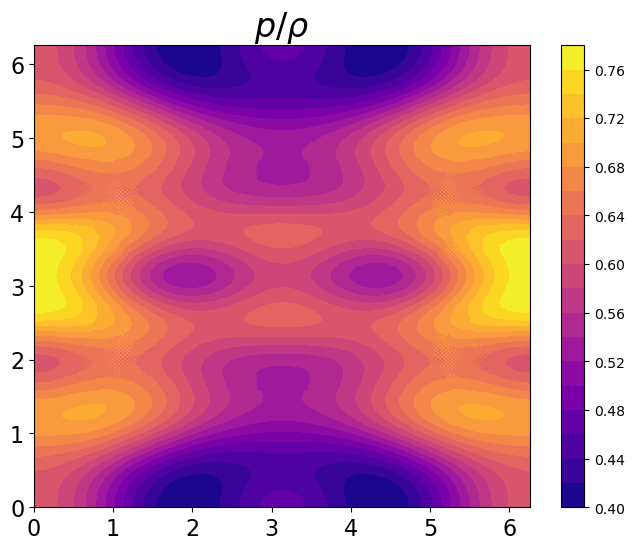

In [49]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

rho = U[0, :, :]
u = U[1, :, :] / rho 
v = U[2, :, :] / rho 
w = U[3, :, :] / rho 
Bx = U[4, :, :]
By = U[5, :, :]
Bz = U[6, :, :]
e = U[7, :, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

contour = ax1.contourf(X, Y, (p/rho).T, levels=20, cmap='plasma')
cbar = plt.colorbar(contour, ax=ax1)

ax1.set_title(r"$p/\rho$", fontsize=24)
ax1.tick_params(labelsize=16)

plt.show()